In [ ]:
# !pip install pandas matplotlib

In [51]:
from typing import List, Dict, Tuple

import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

__WORKING_BRANCH_PATH = (
    "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch"
)

hatch = {
    'Vector': '',
    'Vectorpreallocated': '||||',
    'Skiplist': '\\\\\\\\\\\\',
    'Hashskiplist': '//',
    'Hashlinklist': '----',
    'Mean': '',
    'Median': '||||||',
    'Max': '\\\\\\\\\\\\',
    '95th': '//',
    '98th': '----',
    '99th': '\\\\'
}

linestyle = {
    'vector': '-',
    'vectorpreallocated': '--',
    'skiplist': '--',
    'hashskiplist': '-.',
    'hashlinklist': ':'
}

alpha = {
    'Vector': 1,
    'Vectorpreallocated': 1,
    'Skiplist': 0.8,
    'Hashskiplist': 1,
    'Hashlinklist': 1,
}

color = {
    # 'Vector': 'darkslateblue',
    # 'Skiplist': 'slategray',
    # 'Hashskiplist': 'darkkhaki',
    # 'Hashlinklist': 'chocolate'
    'Vector': 'black',
    'Vectorpreallocated': 'black',
    'Skiplist': 'black',
    'Hashskiplist': 'black',
    'Hashlinklist': 'black'
}

linewidth = {
    'Vector': 1,
    'Vectorpreallocated': 1,
    'Skiplist': 1,
    'Hashskiplist': 1,
    'Hashlinklist': 1,
}

edgecolor = {
    'Vector': 'black',
    'Vectorpreallocated': 'black',
    'Skiplist': 'black',
    'Hashskiplist': 'black',
    'Hashlinklist': 'black',
    'Mean': 'black',
    'Median': 'black',
    'Max': 'black',
    '95th': 'black',
    '98th': 'black',
    '99th': 'black'
}

label = {
    'vector': 'vector',
    'vectorpreallocated': 'vector preallocated',
    'skiplist': 'skiplist',
    'hashskiplist': 'hash skiplist',
    'hashlinklist': 'hash linklist',
    'Mean': 'mean',
    'Median': 'median',
    'Max': 'max',
    '95th': '95th',
    '98th': '98th',
    '99th': '99th'
}

plt.rcParams["font.family"] = "serif"

alphabets = "abcdefghijklmnopqrstuvwxyz"

In [52]:
def get_properties(key: str) -> Dict[str, str]:
    if key.lower() in label:
        return {
            # "label": label.get(key.capitalize()),
            "color": "black",
            # "edgecolor": edgecolor.get(key.capitalize()) or "None",
            "linestyle": linestyle.get(key.lower()),
            # "hatch": hatch.get(key.capitalize()),
            # "linewidth": linewidth.get(key.capitalize()),
            # "alpha": alpha.get(key.capitalize()),
        }
    else:
        raise ValueError(f"Unknown key: {key}")

In [53]:
def get_exp_dirname(query_type: str, selectivity: float, entry_size: int, pqs: int, epp: int) -> str:
    return (
        f"{__WORKING_BRANCH_PATH}/experiments-{query_type}-{selectivity}-{entry_size}-{epp}-PQS-{pqs}"
    )


def get_log_file_path(
    query_type: str,
    inserts: int,
    point_queries: int,
    range_queries: int,
    selectivity: float,
    memtable: str,
    entry_size: int,
    number_of_entries_per_page: int,
    number_of_pages: int,
    prefixlen: int = 0,
    bucket_count: int = 0,
    size_ratio: int = 4,
    updates: int = 0,
):
    if memtable.lower() in ("hashskiplist", "hashlinklist"):
        return f"{get_exp_dirname(query_type, selectivity, entry_size, point_queries, number_of_entries_per_page)}/I {inserts} U {updates} S {range_queries} Y {selectivity} Q {point_queries} m {memtable.lower()} E {entry_size} B {number_of_entries_per_page} P {number_of_pages} T {size_ratio} l {prefixlen} bucket_count {bucket_count}/workload.log"
    return f"{get_exp_dirname(query_type, selectivity, entry_size, point_queries, number_of_entries_per_page)}/I {inserts} U {updates} S {range_queries} Y {selectivity} Q {point_queries} m {memtable.lower()} E {entry_size} B {number_of_entries_per_page} P {number_of_pages} T {size_ratio}/workload.log"

In [54]:
def prepare_dataframe(log_file_path: str, key: str="RangeQueryTime: ") -> pd.DataFrame:
    ff = open(log_file_path, "r")
    range_quereis = []

    for line in ff.readlines():
        if key in line:
            range_quereis.append(float(line.split(" ")[1]))
    
    return pd.DataFrame(range_quereis, columns=["TimeTaken"])

def process_file(path):
    ff = open(path, "r")

    for line in ff.readlines():
        if "Total time taken by workload =" in line:
            return float(line.split("Total time taken by workload = ")[1].split(" ")[0]) / 1000

In [68]:
point_queries = [0] #, 120, 2400, 7200, 12000]
memtables = ["Hashskiplist", "Hashlinklist"]
prefixlen = 8
bucket_counts = [1, 10, 20, 40, 60, 80, 100]  #, 500, 1000, 5000, 10000, 20000, 40000, 60000, 80000, 100000]
entry_size = 64
inserts = 180000
range_queries = 0
number_of_entries_per_page = 64
number_of_pages = 4096
updates = 0
selectivity = 0


data = {
    "vector": [],
    "skiplist": [], 
    "hashskiplist": [], 
    "hashlinklist": [],
}

for pqs in point_queries:

    for memtable in memtables:
        for bucket_count in bucket_counts:
            query_type = "Motivation-bbc-"
            query_type += memtable.lower()

            path = get_log_file_path(
                query_type,
                inserts,
                pqs,
                range_queries,
                selectivity,
                memtable,
                entry_size,
                number_of_entries_per_page,
                number_of_pages,
                prefixlen,
                bucket_count,
            )

            # df = prepare_dataframe(path, "PointQueryTime:")
            total_operations = inserts
            avg_operational_latency = process_file(path) / total_operations

            print
            data[memtable.lower()].append({
                "pointQueries": pqs,
                "bucketCount": bucket_count,
                "prefixlen": prefixlen,
                "AvgPointQueryLatency": avg_operational_latency
            })


In [56]:
bucket_counts

[1, 10, 20, 40, 60, 80, 100]

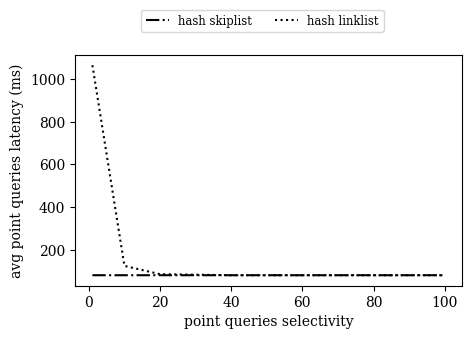

In [71]:
fig, ax = plt.subplots(figsize=(5,3))

xpoints = [b for b in bucket_counts]

# ax.plot(
#     xpoints,
#     [d['AvgPointQueryLatency'] for d in sorted(data['vector'], key=lambda x: x['pointQueries'])],
#     label='vector',
#     **get_properties('vector'),
#     marker='o'
# )

# ax.plot(
#     xpoints,
#     [d['AvgPointQueryLatency'] for d in sorted(data['skiplist'], key=lambda x: x['pointQueries'])],
#     label='skiplist',
#     **get_properties('skiplist'),
#     marker='x'
# )

ax.plot(
    xpoints,
    [d['AvgPointQueryLatency'] for d in sorted(data['hashskiplist'], key=lambda x: x['pointQueries'])],
    label='hash skiplist',
    **get_properties('hashskiplist'),
    # marker='s'
)

ax.plot(
    xpoints,
    [d['AvgPointQueryLatency'] for d in sorted(data['hashlinklist'], key=lambda x: x['pointQueries'])],
    label='hash linklist',
    **get_properties('hashlinklist'),
    # marker='^'
)

# ax.set_xticks(xpoints)
# ax.set_xticklabels([b for b in bucket_counts])

ax.set_ylabel('avg point queries latency (ms)')
ax.set_xlabel('point queries selectivity')
# ax.set_ylim(bottom=10**1)
# ax.set_xlim(left=10**1)

# ax.set_xscale('log')

# ax.legend()
# ax.set_yscale('log')

fig.legend(loc='upper center', ncol=4, fontsize='small', bbox_to_anchor=(0.5, 1.05))
plt.show()

In [58]:
data

{'vector': [],
 'skiplist': [],
 'hashskiplist': [{'pointQueries': 0,
   'bucketCount': 1,
   'prefixlen': 8,
   'AvgPointQueryLatency': 64.34063812000001},
  {'pointQueries': 0,
   'bucketCount': 10,
   'prefixlen': 8,
   'AvgPointQueryLatency': 64.19156450666668},
  {'pointQueries': 0,
   'bucketCount': 20,
   'prefixlen': 8,
   'AvgPointQueryLatency': 64.1777608},
  {'pointQueries': 0,
   'bucketCount': 40,
   'prefixlen': 8,
   'AvgPointQueryLatency': 64.17705298666667},
  {'pointQueries': 0,
   'bucketCount': 60,
   'prefixlen': 8,
   'AvgPointQueryLatency': 64.17070342666666},
  {'pointQueries': 0,
   'bucketCount': 80,
   'prefixlen': 8,
   'AvgPointQueryLatency': 64.16956800666667},
  {'pointQueries': 0,
   'bucketCount': 100,
   'prefixlen': 8,
   'AvgPointQueryLatency': 64.16427868666666}],
 'hashlinklist': [{'pointQueries': 0,
   'bucketCount': 1,
   'prefixlen': 8,
   'AvgPointQueryLatency': 563.0339907266666},
  {'pointQueries': 0,
   'bucketCount': 10,
   'prefixlen': 8,
